## 34207147 Jee Eun Kim

## 3.Unsupervised Learning

Question 3 [Self-supervised Neural Network Learning, 2+8+2+8+8+7=35 Marks]

### I. Load Task2C labeled.csv, Task2C unlabeled.csv, and Task2C test.csv datasets, along with the required libraries. Note that we will use both Task2C labeled.csv and Task2C unlabeled.csv to train the autoencoder, and only Task2C labeled.csv to train the classifiers. Finally, we will evaluate the trained classifier on the test dataset Task2C test.csv.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Path
file_path_labeled = '/Users/jeeeunkim/Desktop/[FIT5201]ML/ass2/Ass2 dataset/Task2C_labeled.csv'
file_path_unlabeled = '/Users/jeeeunkim/Desktop/[FIT5201]ML/ass2/Ass2 dataset/Task2C_unlabeled.csv'
file_path_test = '/Users/jeeeunkim/Desktop/[FIT5201]ML/ass2/Ass2 dataset/Task2C_test.csv'

# Read data from CSV
labeled_data = pd.read_csv(file_path_labeled)
unlabeled_data = pd.read_csv(file_path_unlabeled)
test_data = pd.read_csv(file_path_test)

# Split labeled data into features and labels
X_labeled = labeled_data.drop(columns=['label']).values
y_labeled = labeled_data['label'].values
X_unlabeled = unlabeled_data.values
X_test = test_data.drop(columns=['label']).values
y_test = test_data['label'].values

# Scale data using StandardScaler
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)
X_test_scaled = scaler.transform(X_test)

# Convert data to tensors for PyTorch
X_labeled_tensor = torch.tensor(X_labeled_scaled, dtype=torch.float32)
y_labeled_tensor = torch.tensor(y_labeled, dtype=torch.long)
X_unlabeled_tensor = torch.tensor(X_unlabeled_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Print data sizes
print(f"Labeled Data Size: {X_labeled_tensor.shape}, {y_labeled_tensor.shape}")
print(f"Unlabeled Data Size: {X_unlabeled_tensor.shape}")
print(f"Test Data Size: {X_test_tensor.shape}, {y_test_tensor.shape}")


Labeled Data Size: torch.Size([50, 784]), torch.Size([50])
Unlabeled Data Size: torch.Size([1500, 784])
Test Data Size: torch.Size([500, 784]), torch.Size([500])


### II. Train an autoencoder with only one hidden layer and change the number of its neurons to 20, 60, 100, ..., 220 (i.e. from 20 to 220 with a step size of 40).

In [49]:
# Combine labeled and unlabeled datasets for Autoencoder training
X_combined = torch.cat((X_labeled_tensor, X_unlabeled_tensor), dim=0)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
        )
        
        # Apply Xavier initialization
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    # Xavier initialization function
    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

# Set hyperparameters
input_dim = X_combined.shape[1] # Input dimension (number of features)
hidden_dims = list(range(20, 221, 40))  # Hidden layer sizes from 20 to 220 with step size of 40
num_epochs = 200
learning_rate = 0.001

for hidden_dim in hidden_dims:
    # Initialize the model
    autoencoder = Autoencoder(input_dim, hidden_dim)
    criterion = nn.MSELoss()  # Loss function
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        _, decoded = autoencoder(X_combined)  # Use only decoded output
        loss = criterion(decoded, X_combined)  # Calculate loss with decoded output

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the final loss for each hidden layer size
    print(f"Hidden Layer Neurons: {hidden_dim} - Model Trained with Loss: {loss.item():.6f}")

    # Save the model
    model_path = f'autoencoder_hidden_{hidden_dim}.pth'
    torch.save(autoencoder.state_dict(), model_path)


Hidden Layer Neurons: 20 - Model Trained with Loss: 10.799595
Hidden Layer Neurons: 60 - Model Trained with Loss: 3.826940
Hidden Layer Neurons: 100 - Model Trained with Loss: 2.334126
Hidden Layer Neurons: 140 - Model Trained with Loss: 1.566823
Hidden Layer Neurons: 180 - Model Trained with Loss: 1.196912
Hidden Layer Neurons: 220 - Model Trained with Loss: 1.015459


### III. For each model in Step II, calculate and record the reconstruction error for the autoencoder, which is simply the average of Euclidean distances between the input and output of the autoencoder. Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. Then, explain your findings based on the plot.

Hidden Layer Neurons: 20 - Reconstruction Error (Euclidean): 58.401188
Hidden Layer Neurons: 60 - Reconstruction Error (Euclidean): 39.976528
Hidden Layer Neurons: 100 - Reconstruction Error (Euclidean): 32.977577
Hidden Layer Neurons: 140 - Reconstruction Error (Euclidean): 28.310211
Hidden Layer Neurons: 180 - Reconstruction Error (Euclidean): 25.511168
Hidden Layer Neurons: 220 - Reconstruction Error (Euclidean): 23.805101


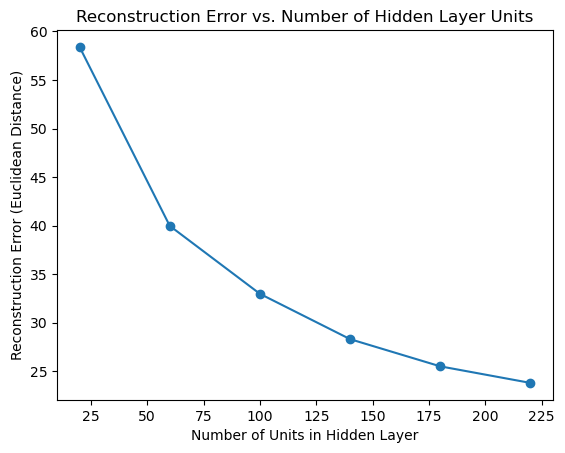

In [51]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(model, data):
    with torch.no_grad():
        _, decoded = model(data)  # Use only the decoded output
        reconstruction_error = torch.sqrt(((data - decoded) ** 2).sum(dim=1)).mean().item()
    return reconstruction_error


# Load trained models and calculate reconstruction errors
reconstruction_errors = []

for hidden_dim in hidden_dims:
    # Load the trained model

    model_path = f'autoencoder_hidden_{hidden_dim}.pth'
    autoencoder = Autoencoder(input_dim, hidden_dim)
    autoencoder.load_state_dict(torch.load(model_path))  # Load saved weights

    # Calculate reconstruction error
    reconstruction_error = calculate_reconstruction_error(autoencoder, X_combined)
    reconstruction_errors.append(reconstruction_error)
    print(f"Hidden Layer Neurons: {hidden_dim} - Reconstruction Error (Euclidean): {reconstruction_error:.6f}")

# Plot the reconstruction errors
plt.plot(hidden_dims, reconstruction_errors, marker='o')
plt.xlabel("Number of Units in Hidden Layer")
plt.ylabel("Reconstruction Error (Euclidean Distance)")
plt.title("Reconstruction Error vs. Number of Hidden Layer Units")
plt.show()


---
### [Analysis]
Examining the graph of the number of hidden units versus reconstruction error reveals the following points:

**1.Decrease in Reconstruction Error with More Hidden Units:** As the number of hidden units increases, the reconstruction error decreases. This is because a higher number of hidden units allows the autoencoder to better capture the features of the input data, enabling more accurate reconstruction.

**2.Gradual Reduction in Error Improvement:** Initially, increasing the number of hidden units results in a significant decrease in reconstruction error, but as more units are added, the improvement becomes progressively smaller.

**3.Optimal Balance:** Although increasing the number of hidden units improves performance, too many units may lead to overfitting. Thus, the point where the curve begins to flatten, such as the **elbow point**, could be considered the optimal number of hidden units.

---

### IV. Build the 3-layer NN to build a classification model using all the original attributes from the training set and change the number of its neurons to 20, 60, 100, ..., 220 (i.e. from 20 to 220 with a step size of 40). For each model, calculate and record the test error.

Hidden Layer Neurons: 20 - Test Error: 0.540000
Hidden Layer Neurons: 60 - Test Error: 0.506000
Hidden Layer Neurons: 100 - Test Error: 0.494000
Hidden Layer Neurons: 140 - Test Error: 0.480000
Hidden Layer Neurons: 180 - Test Error: 0.482000
Hidden Layer Neurons: 220 - Test Error: 0.494000


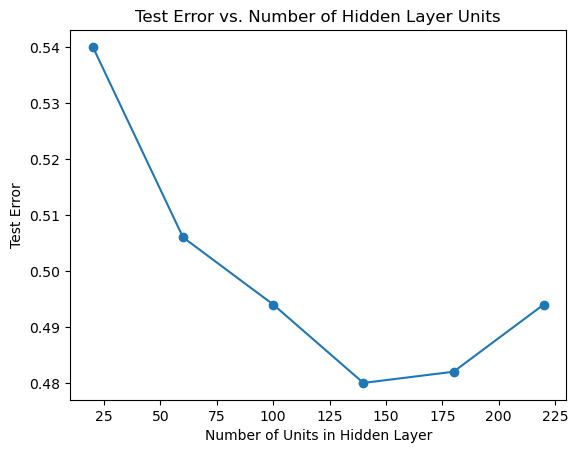

In [53]:
# Define a 3-layer neural network
class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ThreeLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
        # Apply Xavier initialization
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

    # Xavier initialization function
    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

# Set hyperparameters
input_dim = X_labeled_tensor.shape[1]  # Input dimension (number of features)
output_dim = len(torch.unique(y_labeled_tensor))  # Output dimension (number of classes)
hidden_dims = list(range(20, 221, 40))  # List of hidden layer sizes
num_epochs = 100
learning_rate = 0.001

# Store test errors
test_errors = []

# Train and calculate test error for each hidden layer size
for hidden_dim in hidden_dims:
    # Initialize the model
    model = ThreeLayerNN(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()  # Loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_labeled_tensor)
        loss = criterion(outputs, y_labeled_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        test_error = 1 - accuracy_score(y_test_tensor.cpu(), predicted.cpu())
        test_errors.append(test_error)
        print(f"Hidden Layer Neurons: {hidden_dim} - Test Error: {test_error:.6f}")

# Plot test errors
plt.plot(hidden_dims, test_errors, marker='o')
plt.xlabel("Number of Units in Hidden Layer")
plt.ylabel("Test Error")
plt.title("Test Error vs. Number of Hidden Layer Units")
plt.show()


### V. Build augmented self-taught networks using the models learnt in Step II. For each model:
1) Add the output of the middle layer of an autoencoder as extra features to the original feature set
2) Train a new 3-layer Neural Network using all features (original + extra) and varying the number of hidden neurons (like Step IV) as well.
3) Then calculate and record the test error.

Test Errors with Augmented Features for Different Hidden Units:
Hidden Units:  20 | Test Error: 0.5380
Hidden Units:  60 | Test Error: 0.4780
Hidden Units: 100 | Test Error: 0.4820
Hidden Units: 140 | Test Error: 0.4820
Hidden Units: 180 | Test Error: 0.4780
Hidden Units: 220 | Test Error: 0.4600


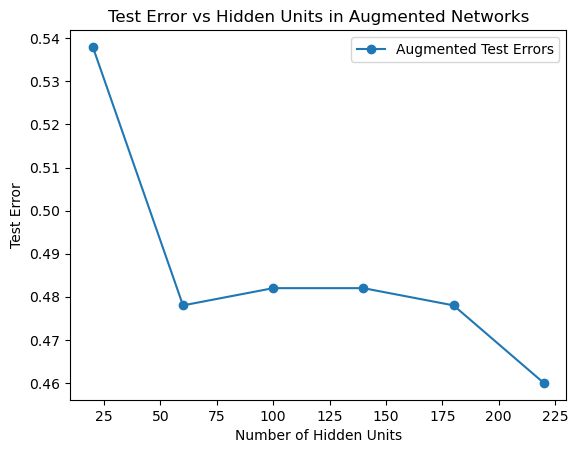

In [54]:
# Function to get the hidden layer output from the Autoencoder
def get_autoencoder_hidden_representation(autoencoder, data):
    autoencoder.eval()
    with torch.no_grad():
        encoded, _ = autoencoder(data)  # Get the encoded (hidden layer) output only
    return encoded

# Function to train and test the Self-Taught Network
def train_and_evaluate_augmented_nn(X_train, y_train, X_test, y_test, hidden_units, autoencoder_hidden_units):
    # Load the pre-trained Autoencoder model from Step II
    autoencoder = Autoencoder(input_dim=X_train.shape[1], hidden_dim=autoencoder_hidden_units)
    model_path = f'autoencoder_hidden_{autoencoder_hidden_units}.pth'
    autoencoder.load_state_dict(torch.load(model_path))
    
    # Create augmented data by adding the hidden layer output from Autoencoder
    X_train_encoded = get_autoencoder_hidden_representation(autoencoder, X_train)
    X_test_encoded = get_autoencoder_hidden_representation(autoencoder, X_test)
    X_train_augmented = torch.cat([X_train, X_train_encoded], dim=1)
    X_test_augmented = torch.cat([X_test, X_test_encoded], dim=1)

    # Train a 3-layer neural network using augmented data
    augmented_input_dim = X_train_augmented.shape[1]
    model = ThreeLayerNN(input_dim=augmented_input_dim, hidden_dim=hidden_units, output_dim=len(torch.unique(y_train)))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(50):  # 50 epochs
        model.train()
        outputs = model(X_train_augmented)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the test error
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_augmented)
        _, predicted = torch.max(test_outputs, 1)
        test_error = 1 - accuracy_score(y_test.cpu(), predicted.cpu())
    
    return test_error

# Calculate test errors for Augmented Self-Taught Network
augmented_test_errors = []
hidden_units_list = hidden_dims  # Using the hidden_dims list from Step IV

for hidden_units in hidden_units_list:
    autoencoder_hidden_units = hidden_units  # Set Autoencoder's hidden_dim same as current hidden units
    error = train_and_evaluate_augmented_nn(X_labeled_tensor, y_labeled_tensor, X_test_tensor, y_test_tensor, hidden_units, autoencoder_hidden_units)
    augmented_test_errors.append(error)

print("Test Errors with Augmented Features for Different Hidden Units:")
for hidden_units, error in zip(hidden_units_list, augmented_test_errors):
    print(f"Hidden Units: {hidden_units:>3} | Test Error: {error:.4f}")

# Plot the test errors
plt.plot(hidden_units_list, augmented_test_errors, marker='o', label='Augmented Test Errors')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Test Error')
plt.title('Test Error vs Hidden Units in Augmented Networks')
plt.legend()
plt.show()


### VI. Plot the error rates for the 3-layer neural networks from Step IV and the augmented self- taught networks from Step V, while the x-axis is the number of hidden neurons and y-axis is the classification error. Explain how the performance of the 3-layer neural networks and the augmented self-taught networks is different and why they are different or why they are not different, based on the plot.

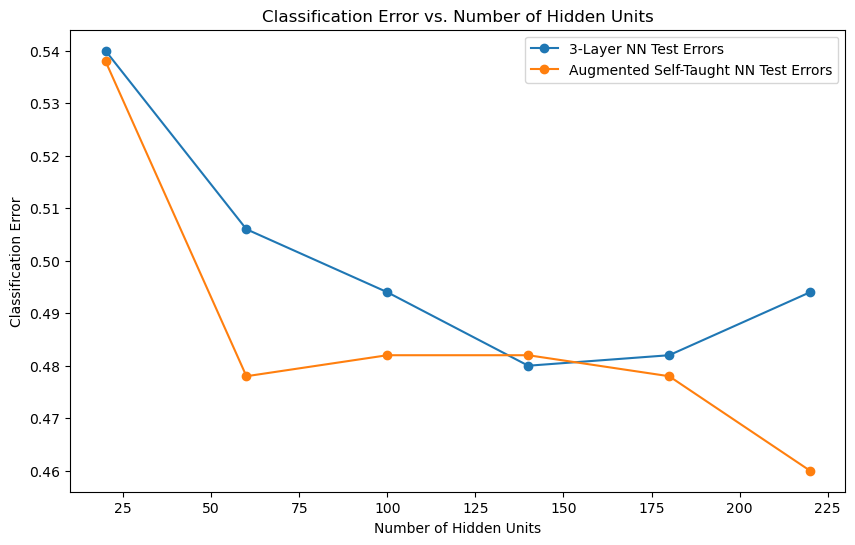

In [55]:
# Plot the classification errors for both models
plt.figure(figsize=(10, 6))
plt.plot(hidden_dims, test_errors, marker='o', label='3-Layer NN Test Errors')
plt.plot(hidden_dims, augmented_test_errors, marker='o', label='Augmented Self-Taught NN Test Errors')
plt.xlabel("Number of Hidden Units")
plt.ylabel("Classification Error")
plt.title("Classification Error vs. Number of Hidden Units")
plt.legend()
plt.show()


---
### [Analysis]

**1. Performance Difference Observation:** In almost all cases, except when the number of hidden units is 140, the Augmented Self-Taught Network shows better performance than the standard 3-layer neural network. The Augmented Self-Taught Network learns with additional information from the middle layer output of the autoencoder, which helps the model better represent the data. However, when the number of hidden units becomes sufficiently large, the standard 3-layer neural network can also achieve good performance.

**2. Model Complexity and Overfitting:** For the standard 3-layer neural network, as the number of hidden units increases beyond 180, the error rate tends to rise. This suggests that the model may be too complex, leading to overfitting. In contrast, the Augmented Network leverages additional features from the autoencoder, which helps balance the model’s complexity, allowing it to maintain stable performance with a decreasing error rate even with a high number of units.



---